In [1]:
pip install openai-whisper --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 47.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 MB 234.7 MB/s eta 0:00:0000:0100:01
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803404 sha256=7fd5e9d8fbaf03d00b4d5c6c94ed8d650c834262a9a5bb4309088b30f002aa75
  Stored in directory: /tmp/pip-ephem-wheel-cache-vstoi7s5/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import time
import torch
import whisper
import librosa
import datetime
import requests
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from collections import Counter

In [3]:
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(64 * 32 * 70, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [4]:
classificatorModel = AudioCNN()
classificatorModel.load_state_dict(torch.load('/kaggle/input/speechmusicclassificator/pytorch/default/2/speech_music_classificator.pth', map_location='cpu', weights_only=True))
classificatorModel.eval()

AudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=143360, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [5]:
languageIdentifierModel = whisper.load_model('medium')

100%|█████████████████████████████████████| 1.42G/1.42G [00:27<00:00, 55.3MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [6]:
streams = [
    {'url': 'https://stream22.tmwradio.com/tmw.mp3',
     'name': 'RMC Sport Network',
     'country': 'Italy'},
    {'url': 'https://station.waveradio.org/soviet',
     'name': 'Soviet Wave',
     'country': 'Russia'}
]

In [7]:
def recorder(stream_url):
    with open('piece.mp3', 'wb') as f:
        r = requests.get(stream_url, stream=True)
        for block in r.iter_content(50000):
            f.write(block)
            break
    return 'piece.mp3'

In [8]:
def language_identifier(audio):
    audio = whisper.load_audio(audio)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio, n_mels=languageIdentifierModel.dims.n_mels)
    _, probs = languageIdentifierModel.detect_language(mel)
    return max(probs, key=probs.get)

In [9]:
def preprocess(audio, sr=48000):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / np.std(log_mel_spectrogram)
    return log_mel_spectrogram # (128, 282)

In [10]:
def speech_music_classificator(audio):
    array, sampling_rate = librosa.load(audio, dtype='float32', sr=48000)
    array = preprocess(array[:144000])
    array = torch.tensor(array).unsqueeze(0).unsqueeze(0).float()
    with torch.no_grad():
        output = classificatorModel(array)
    prediction = output.item()
    prediction = 'music' if prediction < 0.5 else 'speech'
    return prediction

In [11]:
LANGUAGES = {'en': 'english', 'zh': 'chinese', 'de': 'german', 'es': 'spanish', 'ru': 'russian', 'ko': 'korean', 'fr': 'french', 'ja': 'japanese', 'pt': 'portuguese', 'tr': 'turkish', 'pl': 'polish', 'ca': 'catalan', 'nl': 'dutch', 'ar': 'arabic', 'sv': 'swedish', 'it': 'italian', 'id': 'indonesian', 'hi': 'hindi', 'fi': 'finnish', 'vi': 'vietnamese', 'he': 'hebrew', 'uk': 'ukrainian', 'el': 'greek', 'ms': 'malay', 'cs': 'czech', 'ro': 'romanian', 'da': 'danish', 'hu': 'hungarian', 'ta': 'tamil', 'no': 'norwegian', 'th': 'thai', 'ur': 'urdu', 'hr': 'croatian', 'bg': 'bulgarian', 'lt': 'lithuanian', 'la': 'latin', 'mi': 'maori', 'ml': 'malayalam', 'cy': 'welsh', 'sk': 'slovak', 'te': 'telugu', 'fa': 'persian', 'lv': 'latvian', 'bn': 'bengali', 'sr': 'serbian', 'az': 'azerbaijani', 'sl': 'slovenian', 'kn': 'kannada', 'et': 'estonian', 'mk': 'macedonian', 'br': 'breton', 'eu': 'basque', 'is': 'icelandic', 'hy': 'armenian', 'ne': 'nepali', 'mn': 'mongolian', 'bs': 'bosnian', 'kk': 'kazakh', 'sq': 'albanian', 'sw': 'swahili', 'gl': 'galician', 'mr': 'marathi', 'pa': 'punjabi', 'si': 'sinhala', 'km': 'khmer', 'sn': 'shona', 'yo': 'yoruba', 'so': 'somali', 'af': 'afrikaans', 'oc': 'occitan', 'ka': 'georgian', 'be': 'belarusian', 'tg': 'tajik', 'sd': 'sindhi', 'gu': 'gujarati', 'am': 'amharic', 'yi': 'yiddish', 'lo': 'lao', 'uz': 'uzbek', 'fo': 'faroese', 'ht': 'haitian creole', 'ps': 'pashto', 'tk': 'turkmen', 'nn': 'nynorsk', 'mt': 'maltese', 'sa': 'sanskrit', 'lb': 'luxembourgish', 'my': 'myanmar', 'bo': 'tibetan', 'tl': 'tagalog', 'mg': 'malagasy', 'as': 'assamese', 'tt': 'tatar', 'haw': 'hawaiian', 'ln': 'lingala', 'ha': 'hausa', 'ba': 'bashkir', 'jw': 'javanese', 'su': 'sundanese', 'yue': 'cantonese'}

In [12]:
def plot_drawer(statistics, radioname):
    plt.cla
    statistics_counted = {
        'speech': Counter(statistics['speech']),
        'music': Counter(statistics['music'])
    }
    fig, ax = plt.subplots()
    
    size = 0.4
    counted_music = list(statistics_counted['music'].values())
    counted_speech = list(statistics_counted['speech'].values())
    vals = counted_speech + counted_music
    
    cmap = plt.colormaps.get_cmap("tab20c")
    outer_colors = cmap(np.arange(2)*4)
    inner_colors = cmap([1, 2, 5, 6, 9, 10])
    
    labels_inner = list(statistics_counted['speech'].keys()) + list(statistics_counted['music'].keys())
    labels_outer = ['speech', 'music']

    # outer slices
    ax.pie([sum(counted_speech), sum(counted_music)], radius=1, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'), labels=labels_outer)
    
    # inner slices
    ax.pie(vals, radius=1-size, colors=inner_colors,
           wedgeprops=dict(width=size, edgecolor='w'), labels=labels_inner, labeldistance=0.7)
    
    ax.set(aspect='equal', title=radioname)
    plt.legend(loc=(-0.3, 0))
    plt.show()

In [38]:
def system(stream, minutes=1, plots=2):
    statistics = {
        'speech': [],
        'music': []
    }
    start_time = time.time()
    finish_time = start_time + 60 * minutes
    plot_interval = 60 * minutes / plots
    next_plot_time = start_time + plot_interval
    plots_shown = 0
    while time.time() < finish_time:
        current_time = time.time()
        if plots_shown < plots_shown and current_time >= next_plot_time:
            plot_drawer(statistics, f'Plot {plots_shown + 1}')
            plots_shown += 1
            next_plot_time = current_time + interval * (plots_shown + 1)
        audio = recorder(stream['url'])
        language = language_identifier(audio)
        content = speech_music_classificator(audio)
        statistics[content].append(LANGUAGES[language])
    plot_drawer(statistics, f'Final plot')

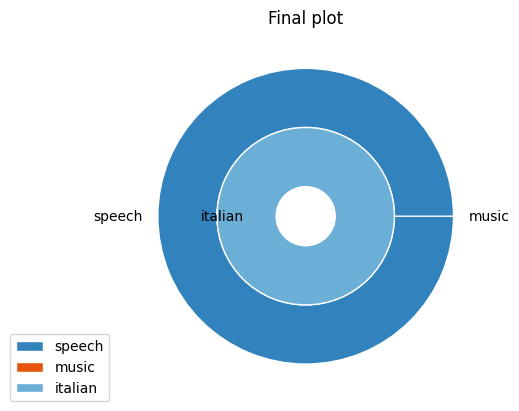

In [39]:
system(streams[0], minutes=10, plots=5)